In [1]:
# imports
import os
from openpyxl import load_workbook
import novosparc
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings("ignore")

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

# Reconstruct Corti

De novo reconstruction of single-cell qRT-PCR measurements of the mammalian organ of corti, the receptor organ for hearing from [Waldhaus et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4465070/). 
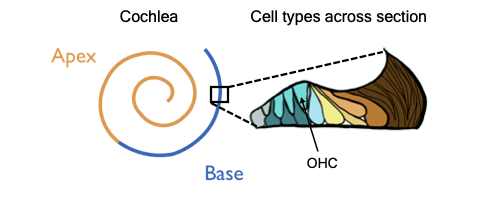

Specifically, we show:
1. recapitulating outer hair cell (OHC) subpopulation base,apex separation when mapping to finer grid of locations
2. recovering expression of genes zonated around either the base or the apex
3. recapitulating base,apex separation for other cell-types

In [2]:
# data
dirname = 'novosparc/datasets/corti'
fname = os.path.join(dirname, 'corti_expression.h5')

In [3]:
# # combine data to scanpy AnnData 
# fname_org = os.path.join(dirname, 'corti_expression.xlsx')

# df_dge = pd.read_excel(fname_org, sheet_name='expression')
# df_loc = pd.read_excel(fname_org, sheet_name='location')
# df_type = pd.read_excel(fname_org, sheet_name='subpopulation')

# df_dge.index = df_dge.index.astype('str')
# df_loc.index = df_loc.index.astype('str')
# df_type.index = df_type.index.astype('str')

# adata = sc.AnnData(df_dge)
# adata.obs = pd.concat((df_loc, df_type), 1)

# adata.write(fname)

In [4]:
# read data
adata = sc.read(fname)
col_anat = 'Anatomical Origin'
col_subp = 'Subpopulation'
genenames = list(adata.var.index)
ngenes = len(genenames)
types = list(adata.obs[col_subp].unique())

print('Number of genes: %d' % ngenes)
print('Number of cells per cell-type: ')
print(adata.obs[col_subp].value_counts())
print()
print('Number of cells per cell-type,location:')
print(adata.obs.groupby([col_subp, col_anat]).size().unstack())

Number of genes: 192
Number of cells per cell-type: 
OHC     205
GER     103
IPC      99
DC12     96
OPC      87
DC3      82
IPH      69
OT       69
IHC      40
IBC      27
Name: Subpopulation, dtype: int64

Number of cells per cell-type,location:
Anatomical Origin  Apex  Base  Middle  nan
Subpopulation                             
DC3                  34    31       0   17
DC12                 24    39       1   32
GER                  51    42       0   10
IBC                   9    12       2    4
IHC                  24    12       2    2
IPC                  34    55       0   10
IPH                  23    22      19    5
OHC                  91    72       3   39
OPC                  37    32       0   18
OT                    9    20       1   39


In [5]:
# filtering cells without location
has_loc = ~(adata.obs[col_anat] == 'nan')
adata = adata[has_loc]

## Recovering Outer Hair Cells(OHCs) Expression

We show first for a single subpopulation, OHC, that we manage to map cells to their anatomical origin 

In [6]:
# subset na location and OHC subpopulation
cell_type = 'OHC'
sadata = adata[adata.obs[col_subp] == cell_type]

In [7]:
# construct target grid
ngrid = 10
grid_locs = np.vstack((range(ngrid),np.ones(ngrid))).T

In [8]:
# construct tissue
tissue = novosparc.cm.Tissue(dataset=sadata, locations=grid_locs)

We construct here cost matrices that better fit this setup, for example, we widen the spectrum of values for location distances by skipping the knn graph construction. 
Specifically, we use:
- expression cost - normalized spearman correlation
- location cost - normalized l1 distance

In [10]:
# cost matrices
def set_costs(tissue, df_dge, grid_locs):
    """
    Sets cost matrices that fit better here
    """
    # expression cost - normalized spearman correlation
    sp_expression = squareform(pdist( df_dge.values, metric='correlation'))
    cost_expression = sp_expression / sp_expression.max()
    cost_expression -= np.mean(cost_expression)

    # location cost - normalized l1 distance
    sp_locations = squareform(pdist(grid_locs, metric='minkowski', p=1))
    cost_locations = sp_locations / sp_locations.max()
    cost_locations -= np.mean(cost_locations)

    tissue.costs['expression'] = cost_expression
    tissue.costs['locations'] = cost_locations
    
set_costs(tissue, sadata.to_df(), grid_locs)

In [12]:
# reconstruction
alpha_linear = 0
tissue.reconstruct(alpha_linear=alpha_linear)

Reconstructing spatial information with 0 markers: 166 cells and 10 locations ... 
Trying with epsilon: 5.00e-04


In [13]:
# fetch results
gw = tissue.gw
sdge = tissue.sdge

df_gw = pd.DataFrame(gw, index=sadata.obs.index) # cells x grid
df_sdge = pd.DataFrame(sdge, index=genenames, columns=df_gw.columns) # grid x genes

def to_flip(df_gw, df_sdge, ann_anat):
    """
    Since we perform de-novo reconstruction, we check if we need to flip axis
    """
    df = pd.DataFrame(ann_anat)
    df['pred loc'] = df_gw.idxmax(1)
    loc_means = df.groupby(col_anat).mean()
    if loc_means.loc['Apex']['pred loc'] < loc_means.loc['Base']['pred loc']:
        df_gw.columns = df_gw.columns[::-1]
        df_sdge.columns = df_sdge.columns[::-1]

to_flip(df_gw, df_sdge, sadata.obs[col_anat])

### Recovering OHCs Anatomical Origin

Looking at the mapping of cells to the grid we constructed, we see a distinction between cells originating from the base and from the apex in terms of the layers they are mapped onto in the virtual grid.

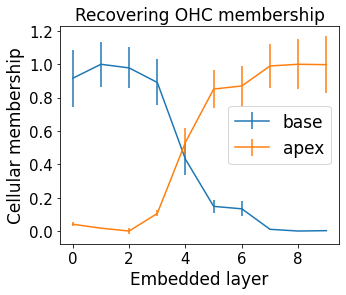

In [14]:
%matplotlib inline
# plot the grid layers apex and base cells are mapped onto
fonts = 17
fonts_ticks=15
    
def plot_cell_mapping(df_gw, ann_anat, type_tit, with_labels=True, legend=True, xticks=None, yticks=None, ylims=None, ax=None, fname=None):
    """
    Plotting mapping of cells to locations by their apex/base annotations.
    """
    col_grid = df_gw.columns
    df_gw[col_anat] = ann_anat
    
    df_zone_to_grid = df_gw.groupby(col_anat)[col_grid].mean() # zone x grid layer
    df_zone_to_grid_sem = df_gw.groupby(col_anat)[col_grid].sem() # zone x grid layer

    df_gw.drop(columns=col_anat, inplace=True)

    base_exp = df_zone_to_grid.loc['Base'].values
    apex_exp = df_zone_to_grid.loc['Apex'].values
    
    def standardize(x, sub_min=None, div_max=None):
        sub_min = x.min() if sub_min is None else sub_min 
        x = x-sub_min
        div_max = x.max() if div_max is None else div_max 
        x = x/div_max
        return x, sub_min, div_max
    
    base_exp, base_min, base_max = standardize(base_exp)
    apex_exp, apex_min, apex_max = standardize(apex_exp)
    
    base_sem = df_zone_to_grid_sem.loc['Base'].values
    apex_sem = df_zone_to_grid_sem.loc['Apex'].values
    
    base_sem,_,_ = standardize(base_sem, base_min, base_max)
    apex_sem,_,_ = standardize(apex_sem, apex_min, apex_max)
    
    with_ax = ax is not None
    
    ax = plt.subplots(figsize=(5,4))[1] if ax is None else ax

    ax.errorbar(col_grid, base_exp, yerr=base_sem)
    ax.errorbar(col_grid, apex_exp, yerr=apex_sem)

    if ylims:
        ax.set_ylim(ylims)
        
    if with_labels:
        ax.set_ylabel('Cellular membership', fontsize=fonts)
        ax.set_xlabel('Embedded layer', fontsize=fonts)
    
    if legend: ax.legend(('base','apex'), fontsize=fonts)
    ax.tick_params(labelsize=fonts_ticks)
    
    if yticks is not None: ax.set_yticks(yticks)
    if xticks is not None: ax.set_xticks(xticks)
    ax.set_title(type_tit, fontsize=fonts)
    
    if not with_ax:
        plt.show() 
        
plot_cell_mapping(df_gw, sadata.obs[col_anat], type_tit='Recovering OHC membership')

### Recovering Expression of Base and Apex

To further validate reconstruction, we examine the spatial expression of genes highlighted in the paper (Figure 7) that are differentially expressed in the apex and base.

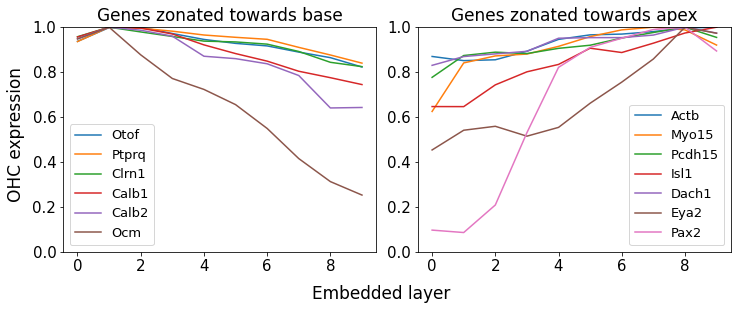

In [15]:
# plot zonated genes
base_genes = ['Otof', 'Ptprq', 'Clrn1','Calb1', 'Calb2', 'Ocm']
apex_genes = ['Actb', 'Myo15', 'Pcdh15','Isl1','Dach1','Eya2','Pax2']

scale_fac = df_sdge.max(1)
df_sdge_norm = df_sdge.T.divide(scale_fac).T

fonts_leg = 13
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(df_sdge_norm.loc[base_genes].T)
plt.title('Genes zonated towards base', fontsize=fonts)
plt.legend((base_genes), fontsize=fonts_leg)
plt.ylim(0,1)
plt.xticks(fontsize=fonts_ticks)
plt.yticks(fontsize=fonts_ticks)

plt.subplot(1,2,2)
plt.plot(df_sdge_norm.loc[apex_genes].T)
plt.legend((apex_genes), fontsize=fonts_leg)
plt.title('Genes zonated towards apex', fontsize=fonts)
plt.ylim(0,1)
plt.yticks(fontsize=fonts_ticks)
plt.xticks(fontsize=fonts_ticks)
fig.text(0.5, -0.05, 'Embedded layer', ha='center',fontsize=fonts)
fig.text(-0.02, 0.52, 'OHC expression', va='center', rotation='vertical',fontsize=fonts)
plt.tight_layout()
plt.show()

<!-- ### Identifying Highly Zonated Genes

Comparing genes that are significantly expressed in base/apex from data and from reconstuction. -->

## Mappings of All Subpopulations

Using few genes that differ in their expression within base and apex regions is sufficient for recovering locations of other subpopulations.

Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 93 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 21 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 36 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 45 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 89 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 69 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 163 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 63 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 65 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


Trying to set attribute `.uns` of view, copying.


Reconstructing spatial information with 0 markers: 29 cells and 5 locations ... 
Trying with epsilon: 5.00e-04


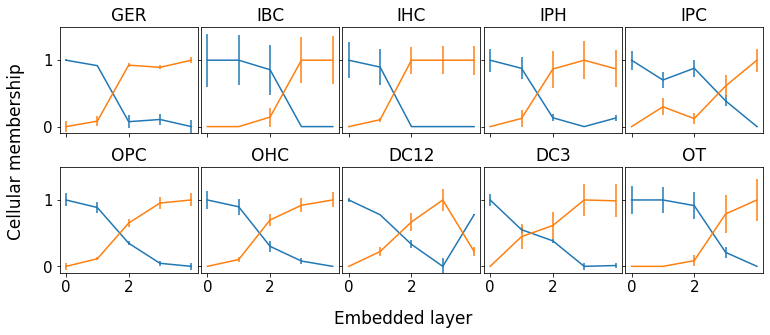

In [16]:
%matplotlib inline
# map each subpopulation

# params
ngrid = 5
n_genes = 30
alpha_linear = 0

# construct target space
grid_locs = np.vstack((range(ngrid),np.ones(ngrid))).T

fig, ax = plt.subplots(2,5, sharex=True, sharey=True, figsize=(10,4))
ax = ax.flatten()

for i_ct, cell_type in enumerate(types):
    # subsetting
    sadata = adata[adata.obs[col_subp] == cell_type]
    
    # select de genes
    sadata = sadata[(sadata.obs[col_anat] == 'Apex') | (sadata.obs[col_anat] == 'Base')]
    sc.tl.rank_genes_groups(sadata, groupby=col_anat, n_genes=n_genes)
    de_genes = list(set(sadata.uns['rank_genes_groups']['names']['Apex']).union(sadata.uns['rank_genes_groups']['names']['Base']))

    # reconstruction
    tissue = novosparc.cm.Tissue(dataset=sadata, locations=grid_locs)
    set_costs(tissue, sadata.to_df()[de_genes], grid_locs)
    tissue.reconstruct(alpha_linear=alpha_linear)
    
    gw = tissue.gw
    sdge = tissue.sdge
    df_gw = pd.DataFrame(gw, index=sadata.obs.index) # cells x grid
    df_sdge = pd.DataFrame(sdge, index=genenames, columns=df_gw.columns) # grid x genes
    to_flip(df_gw, df_sdge, sadata.obs[col_anat])
    
    # plot_cell_mapping(df_gw, type_tit=cell_type)
    yticks = None if i_ct == 0 or i_ct == 5 else [0,1]
    xticks = None if i_ct < 5 else [0,2]
    legend = True if i_ct == 9 else False
    plot_cell_mapping(df_gw, sadata.obs[col_anat], type_tit=cell_type, ax=ax[i_ct], 
                      with_labels=False, legend=False, xticks=xticks, yticks=yticks, 
                      ylims=(-0.1, 1.5),fname=None)

fig.text(0.5, -0.1, 'Embedded layer', ha='center',fontsize=fonts)
fig.text(-0.05, 0.5, 'Cellular membership', va='center', rotation='vertical',fontsize=fonts)
plt.tight_layout(pad=0.0,w_pad=0.0, h_pad=1.0)
plt.show()